Gate median errors (percentage):
id: 0.0002738%
rx: 0.0002738%
rz: 0.0%
sx: 0.0002738%
x: 0.0002738%
cz: 0.001947%
rzz: 0.00249%
Gate: rz, Count: 2900
Gate: sx, Count: 2190
Gate: cz, Count: 2082
Gate: rx, Count: 870
Gate: rzz, Count: 348
Threshold: 0.200000, Expected Fidelity: 0.003141, Total Gates: 8390
Gate: rz, Count: 3248
Gate: sx, Count: 2455
Gate: cz, Count: 2334
Gate: rx, Count: 975
Gate: rzz, Count: 390
Threshold: 0.164584, Expected Fidelity: 0.001564, Total Gates: 9402
Gate: rz, Count: 3616
Gate: sx, Count: 2730
Gate: cz, Count: 2586
Gate: rx, Count: 1080
Gate: rzz, Count: 432
Threshold: 0.135440, Expected Fidelity: 0.000777, Total Gates: 10444
Gate: rz, Count: 3900
Gate: sx, Count: 2950
Gate: cz, Count: 2802
Gate: rx, Count: 1170
Gate: rzz, Count: 468
Threshold: 0.111456, Expected Fidelity: 0.000428, Total Gates: 11290
Gate: rz, Count: 4272
Gate: sx, Count: 3227
Gate: cz, Count: 3054
Gate: rx, Count: 1275
Gate: rzz, Count: 510
Threshold: 0.091720, Expected Fidelity: 0.000213,

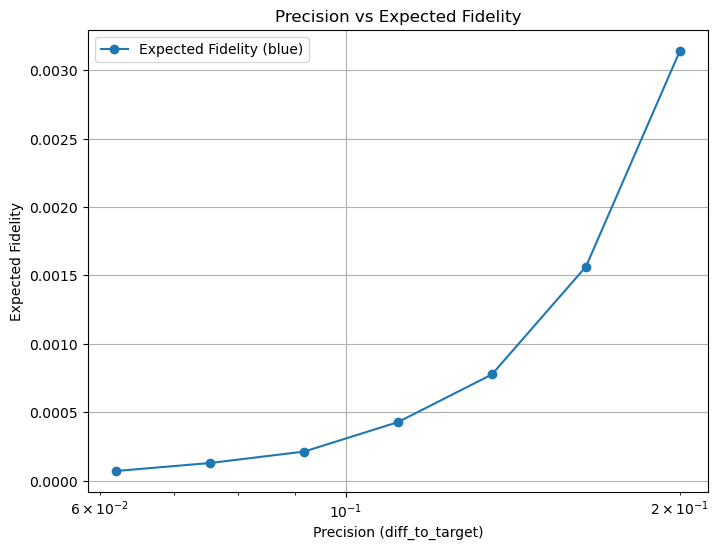

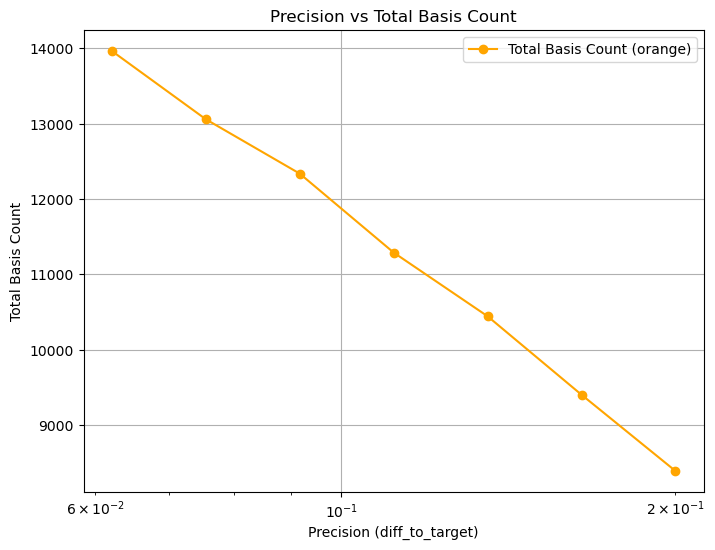

In [1]:
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler import CouplingMap
import matplotlib.pyplot as plt
import numpy as np


n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])


def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h=build_commutator(driver_h, cost_h)

def falqon_layer(qc,cost_h,driver_h,beta_k,delta_t):
    #synth = SuzukiTrotter(reps=1)   ,synthesis=synth
    U_c= PauliEvolutionGate(cost_h,delta_t)
    U_d= PauliEvolutionGate(beta_k*driver_h,delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set =-1.13728383


# 修改 main_loop 增加 diff_threshold 参数
def main_loop_2(qc, cost_h, driver_h, comm_h, delta_t, beta_0, n_steps, diff_threshold):
    beta = [beta_0]
    energies = []
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer, cost_h, driver_h, beta[i], delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta = -1 * state.expectation_value(comm_h).real
        beta.append(next_beta)

        if i >= 1:
            diff_to_target = abs(energies[-1] - E_set)
            if diff_to_target < diff_threshold:
                break

    return beta, energies, qc


def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))  # 对所有 qubit 施加 H 门
    return qc

def calculate_expected_fidelity(gate_error, count_ops, readout_fidelity=1.0):
    fidelity = 1.0
    for gate, error_rate in gate_error.items():
        count = count_ops.get(gate, 0)  # 如果电路里没有这个门，默认 count=0
        fidelity *= (1 - error_rate) ** count
        #print(f"Gate: {gate}, Count: {count}, Error: {error_rate}, Contribution: {(1 - error_rate) ** count:.6f}")
    fidelity *= readout_fidelity
    return fidelity

qc_initial= uniform_superposition_circuit()

n_steps = 1000
beta_0 = 0.0
delta_t = 0.03

basis_gates = ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']

gate_error = {
    "id": 2.738e-4,      # 1-qubit
    "rx": 2.738e-4,      # 1-qubit
    "rz": 0.0,           # 1-qubit
    "sx": 2.738e-4,      # 1-qubit
    "x": 2.738e-4,       # 1-qubit
    "cz": 1.947e-3,      # 2-qubit
    "rzz": 2.490e-3      # 2-qubit
}


coupling_map = CouplingMap.from_full(4)


# 定义线性拓扑：0–1–2–3
linear_coupling = CouplingMap(couplinglist=[(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2),(2, 0), (0, 2)])
linear_coupling2= CouplingMap(couplinglist=[(0, 1), (1, 2), (2, 3),(3,0)])
linear_coupling3= CouplingMap(couplinglist=[(1, 0), (0, 1), (0, 2), (2, 0), (0, 3), (3, 0)])
linear_coupling4= CouplingMap(couplinglist=[(0, 4), (4, 3), (1, 3),(1,0)])
linear_coupling5= CouplingMap(couplinglist=[(0, 2), (2, 0), (2, 3), (3, 2), (1, 3), (3, 1),(1, 0), (0, 1),(1,2), (2, 1)])
# Print out for checking
print("Gate median errors (percentage):")
for gate, error in gate_error.items():
    print(f"{gate}: {error}%")


# 生成 diff_to_target 阈值数组
precision_list = np.logspace(np.log10(0.2), np.log10(0.0001), 40)
fidelity_list = []

total_count_list = []  # 存储每个 precision 下的 gate 总数
for threshold in precision_list:
    # 初始化电路
    qc_initial = uniform_superposition_circuit()
    
    # 运行 main_loop
    beta_list, energy_list, final_circuit = main_loop_2(
        qc=qc_initial,
        cost_h=cost_h,
        driver_h=driver_h,
        comm_h=comm_h,
        delta_t=delta_t,
        beta_0=beta_0,
        n_steps=n_steps,
        diff_threshold=threshold
    )

    # Transpile 电路
    transpiled_circuit = transpile(
        final_circuit,
        basis_gates=basis_gates,
        coupling_map=linear_coupling,
        optimization_level=1
    )

    # 统计 gate count
    gate_counts = transpiled_circuit.count_ops()
    total_count = sum(gate_counts.values())  # 所有 gate 总数
    total_count_list.append(total_count)
    for gate, count in transpiled_circuit.count_ops().items():
        print(f"Gate: {gate}, Count: {count}")


    # 计算 expected fidelity
    expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)
    fidelity_list.append(expected_fidelity)
    print(f"Threshold: {threshold:.6f}, Expected Fidelity: {expected_fidelity:.6f}, Total Gates: {total_count}")

    if fidelity_list[-1] < 0.0001:
        print("Expected fidelity reached zero, exiting loop early.")
        break

# 绘图1: Precision vs Expected Fidelity
plt.figure(figsize=(8, 6))
plt.plot(precision_list[:len(fidelity_list)], fidelity_list, marker='o', label='Expected Fidelity (blue)')
plt.xscale('log')
plt.xlabel('Precision (diff_to_target)')
plt.ylabel('Expected Fidelity')
plt.title('Precision vs Expected Fidelity')
plt.grid(True)
plt.legend()
plt.show()

# 绘图2: Precision vs Total Basis Count (橙色)
plt.figure(figsize=(8, 6))
plt.plot(precision_list[:len(total_count_list)], total_count_list, marker='o', color='orange', label='Total Basis Count (orange)')
plt.xscale('log')
plt.xlabel('Precision (diff_to_target)')
plt.ylabel('Total Basis Count')
plt.title('Precision vs Total Basis Count')
plt.grid(True)
plt.legend()
plt.show()